In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import seaborn as sns

import trompy as tp

from scipy.stats import pearsonr

colors_PVH = "#af9991"
colors_VMH  = "#F4A6B1"

colors = [colors_PVH, colors_VMH]

cmap = "RdBu_r"

In [7]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")
STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper")

with open(DATAFOLDER / "adlib_sucralose.pickle", 'rb') as handle:
    PVH = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_sucralose.pickle", 'rb') as handle:
    VMH = pickle.load(handle)        

In [8]:
PVH_list_of_mice = []
VMH_list_of_mice = []

mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                    "HL202", "HL205", "HL206", "HL211",
                    "HL301", "HL304", "HL305"]

#"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
#HL 306, 308 have no virus
#HL301, HL304, HL305 have poor fiber placement
#HL313 - HL318 are control mice


for key, val in PVH.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in PVH_list_of_mice:
            PVH_list_of_mice.append(val["mouse_ID"])
        
for key, val in VMH.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in VMH_list_of_mice:
            VMH_list_of_mice.append(val["mouse_ID"])

In [9]:
VMH_list_of_mice

['HL302', 'HL303', 'HL307', 'HL309', 'HL310', 'HL311', 'HL312']

In [10]:
def get_aucs(data, mouse):
    
    pre = 5
    post = 10
    mineventlength = 8
    binlength = 0.1

    snips_full = []
    run_lengths = []

    for key, val in data.items():
        if val["mouse_ID"] == mouse:
            if len(val["licks"]) < 10:
                continue

            lickdata = tp.lickCalc(val["licks"], minrunlength=3)

            snipper = tp.Snipper(val["corrected"],
                                 lickdata["rStart"],
                                 end=lickdata["rEnd"],
                                 fs=val["fs"],
                                 pre=pre,
                                 post=post,
                                 binlength=binlength,
                                 zscore=True
                                 )
            
            snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6,2])
            snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
            plt.plot(snipper.snips.T, color="black", alpha=0.1)
            snips_full.append(snipper.snips)
            
            print(snipper.snips.shape)
            
            run_lengths_temp = (np.array(lickdata["rEnd"]) - np.array(lickdata["rStart"]))
            run_lengths.append(run_lengths_temp[run_lengths_temp > mineventlength])
        
    try:
        snips_full = np.vstack(snips_full)
        print("adding this mouse")
    except:
        print("no snips to concatenate")
        
    run_lengths = tp.flatten_list(run_lengths)

    # Normalizing AUC calculations to epoch length
    auc_early_licking = np.trapz(snips_full[:, 50:110], axis=1) / 60 #60 because 6 seconds
    auc_late_licking = np.trapz(snips_full[:, 120:140], axis=1) / 20  #2 seconds
    auc_early_post_licking = np.trapz(snips_full[:, 140:190], axis=1) / 50 # 5 seconds
    auc_late_post_licking = np.trapz(snips_full[:, 190:240], axis=1) / 50 # 5 seconds
    
    return snips_full, pd.DataFrame([run_lengths,
                                    auc_early_licking,
                                    auc_late_licking,
                                    auc_early_post_licking,
                                    auc_late_post_licking],
                                    
                                    index=["run_lengths", "auc_early_licking", "auc_late_licking", "auc_early_post_licking", "auc_late_post_licking"]).T
    

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(2, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(5, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0.0 potential artifacts.
No artifacts found.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

ZeroDivisionError: integer division or modulo by zero

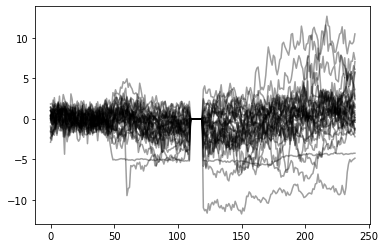

In [11]:
pvh_data = {}
for mouse in PVH_list_of_mice:
    snips, pvh_data[mouse] = get_aucs(PVH, mouse)
    

In [12]:
def get_correlation_matrix(auc_data):
    
    auc_data_concat = pd.concat(auc_data)
    
    corrmat = auc_data_concat.corr()
    
    return corrmat

corrs = get_correlation_matrix(pvh_data)

In [13]:
pvh_data_concat = pd.concat(pvh_data)

In [14]:
pvh_data_concat = pd.concat(pvh_data)

# Define thresholds based on standard deviation
early_threshold = np.std(pvh_data_concat['auc_early_licking']) * 3
early_qs = "auc_early_licking < @early_threshold and auc_early_licking > -@early_threshold"

late_threshold = np.std(pvh_data_concat['auc_late_licking']) * 3
late_qs = "auc_late_licking < @late_threshold and auc_late_licking > -@late_threshold"

early_post_threshold = np.std(pvh_data_concat['auc_early_post_licking']) * 3
early_post_qs = "auc_early_post_licking < @early_post_threshold and auc_early_post_licking > -@early_post_threshold"

late_post_threshold = np.std(pvh_data_concat['auc_late_post_licking']) * 3
late_post_qs = "auc_late_post_licking < @late_post_threshold and auc_late_post_licking > -@late_post_threshold"

# Combine query strings
query_string = f"{early_qs} and {late_qs} and {early_post_qs} and {late_post_qs}"
filtered_pvh = pvh_data_concat.query(query_string)

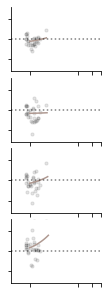

In [15]:
def plot_scatter_and_line_of_best_fit(x, y, ax, color, alpha=0.1, size=10):
    ax.scatter(x, y, color="black", alpha=alpha, s=size)  # 's' controls the size of the dots
    
    slope, intercept = np.polyfit(x, y, 1)
    xrange = np.linspace(10, ax.get_xlim()[1], 100)
    line = slope * xrange + intercept
    
    ax.plot(xrange, line, color=color) 

    return ax

f, ax = plt.subplots(nrows=4, figsize=(1.3,4),
                     sharex=True,
                     gridspec_kw={"hspace":0.1, "wspace":0.1,
                                  "left": 0.02,
                                  "right": 0.98,
                                  "top": 0.98,
                                  "bottom": 0.02})


plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                  filtered_pvh.auc_early_licking,
                                  ax[0],
                                  colors_PVH,
)

plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                  filtered_pvh.auc_late_licking,
                                  ax[1],
                                  colors_PVH
)

plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                  filtered_pvh.auc_early_post_licking,
                                  ax[2],
                                  colors_PVH
)

plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                  filtered_pvh.auc_late_post_licking,
                                  ax[3],
                                  colors_PVH
)

for axis in ax:
    axis.axhline(0, linestyle="dotted", color="black", alpha=0.5)
    axis.set_xscale("log")
    axis.set_ylim(-8, 8)
    axis.set_yticklabels([])
    axis.set_xlim(4, 300)
    axis.set_xticks([10, 100, 200, 300])
    axis.set_xticklabels([])
    
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)

f.savefig(FIGSFOLDER / "PVH_licking_correlations_SUCRALOSE.pdf")

In [16]:
### STATISTICS FOR PVH

# Compute Pearson correlation coefficients and p-values
corr_early, p_value_early = pearsonr(filtered_pvh.run_lengths, filtered_pvh.auc_early_licking)
corr_late, p_value_late = pearsonr(filtered_pvh.run_lengths, filtered_pvh.auc_late_licking)
corr_early_post, p_value_early_post = pearsonr(filtered_pvh.run_lengths, filtered_pvh.auc_early_post_licking)
corr_late_post, p_value_late_post = pearsonr(filtered_pvh.run_lengths, filtered_pvh.auc_late_post_licking)

print(f"Early AUC vs. Run Length: r={corr_early:.3f}, p={p_value_early:.3f}")
print(f"Late AUC vs. Run Length: r={corr_late:.3f}, p={p_value_late:.3f}")
print(f"Early Post AUC vs. Run Length: r={corr_early_post:.3f}, p={p_value_early_post:.3f}")
print(f"Late Post AUC vs. Run Length: r={corr_late_post:.3f}, p={p_value_late_post:.3f}")

#TO EXPORT TO CSV

# Ensure all relevant columns are numeric
filtered_pvh['run_lengths'] = pd.to_numeric(filtered_pvh['run_lengths'], errors='coerce')
filtered_pvh['auc_early_licking'] = pd.to_numeric(filtered_pvh['auc_early_licking'], errors='coerce')
filtered_pvh['auc_late_licking'] = pd.to_numeric(filtered_pvh['auc_late_licking'], errors='coerce')
filtered_pvh['auc_early_post_licking'] = pd.to_numeric(filtered_pvh['auc_early_post_licking'], errors='coerce')
filtered_pvh['auc_late_post_licking'] = pd.to_numeric(filtered_pvh['auc_late_post_licking'], errors='coerce')

# Create a DataFrame with all relevant columns
data_for_export = pd.DataFrame({
    'Run_Lengths': filtered_pvh['run_lengths'],
    'AUC_Early_Licking': filtered_pvh['auc_early_licking'],
    'AUC_Late_Licking': filtered_pvh['auc_late_licking'],
    'AUC_Early_Post_Licking': filtered_pvh['auc_early_post_licking'],
    'AUC_Late_Post_Licking': filtered_pvh['auc_late_post_licking']
})

# Export the DataFrame to a CSV file
#data_for_export.to_excel(STATSFOLDER /'PVH_correlations_filtered_pvh_data.xlsx', index=False)

Early AUC vs. Run Length: r=0.175, p=0.356
Late AUC vs. Run Length: r=0.017, p=0.929
Early Post AUC vs. Run Length: r=0.180, p=0.340
Late Post AUC vs. Run Length: r=0.240, p=0.202


<ipython-input-16-97a5357ae28a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pvh['run_lengths'] = pd.to_numeric(filtered_pvh['run_lengths'], errors='coerce')
<ipython-input-16-97a5357ae28a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pvh['auc_early_licking'] = pd.to_numeric(filtered_pvh['auc_early_licking'], errors='coerce')
<ipython-input-16-97a5357ae28a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

Analysis for VMH

<class 'numpy.ndarray'>
Found 1 potential artifacts.
(5, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(2, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
adding this mouse


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

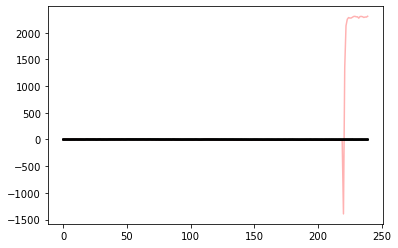

In [17]:
vmh_data = {}
for mouse in VMH_list_of_mice:
    snips, vmh_data[mouse] = get_aucs(VMH, mouse)

In [18]:
vmh_data_concat = pd.concat(vmh_data)

# Define thresholds based on standard deviation
early_threshold = np.std(vmh_data_concat['auc_early_licking']) * 3
early_qs = "auc_early_licking < @early_threshold and auc_early_licking > -@early_threshold"

late_threshold = np.std(vmh_data_concat['auc_late_licking']) * 3
late_qs = "auc_late_licking < @late_threshold and auc_late_licking > -@late_threshold"

early_post_threshold = np.std(vmh_data_concat['auc_early_post_licking']) * 3
early_post_qs = "auc_early_post_licking < @early_post_threshold and auc_early_post_licking > -@early_post_threshold"

late_post_threshold = np.std(vmh_data_concat['auc_late_post_licking']) * 3
late_post_qs = "auc_late_post_licking < @late_post_threshold and auc_late_post_licking > -@late_post_threshold"

# Combine query strings
query_string = f"{early_qs} and {late_qs} and {early_post_qs} and {late_post_qs}"
filtered_vmh = vmh_data_concat.query(query_string)

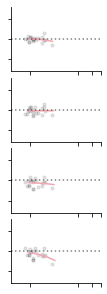

In [19]:
f, ax = plt.subplots(nrows=4, figsize=(1.3,4),
                     sharex=True,
                     gridspec_kw={"hspace":0.1, "wspace":0.1,
                                  "left": 0.02,
                                  "right": 0.98,
                                  "top": 0.98,
                                  "bottom": 0.02})

plot_scatter_and_line_of_best_fit(filtered_vmh.run_lengths,
                                  filtered_vmh.auc_early_licking,
                                  ax[0],
                                  colors_VMH
)

plot_scatter_and_line_of_best_fit(filtered_vmh.run_lengths,
                                  filtered_vmh.auc_late_licking,
                                  ax[1],
                                  colors_VMH
)

plot_scatter_and_line_of_best_fit(filtered_vmh.run_lengths,
                                  filtered_vmh.auc_early_post_licking,
                                  ax[2],
                                  colors_VMH
)

plot_scatter_and_line_of_best_fit(filtered_vmh.run_lengths,
                                  filtered_vmh.auc_late_post_licking,
                                  ax[3],
                                  colors_VMH
)

for axis in ax:
    axis.axhline(0, linestyle="dotted", color="black", alpha=0.5)
    axis.set_xscale("log")
    axis.set_ylim(-8, 8)
    axis.set_yticklabels([])
    axis.set_xlim(4, 300)
    axis.set_xticks([10, 100, 200, 300])
    axis.set_xticklabels([])
    
        
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)

f.savefig(FIGSFOLDER / "VMH_licking_correlations_SUCRALOSE.pdf")

In [20]:
### STATISTICS FOR VMH

# Compute Pearson correlation coefficients and p-values for VMH
corr_early, p_value_early = pearsonr(filtered_vmh.run_lengths, filtered_vmh.auc_early_licking)
corr_late, p_value_late = pearsonr(filtered_vmh.run_lengths, filtered_vmh.auc_late_licking)
corr_early_post, p_value_early_post = pearsonr(filtered_vmh.run_lengths, filtered_vmh.auc_early_post_licking)
corr_late_post, p_value_late_post = pearsonr(filtered_vmh.run_lengths, filtered_vmh.auc_late_post_licking)

print(f"Early AUC vs. Run Length: r={corr_early:.3f}, p={p_value_early:.3f}")
print(f"Late AUC vs. Run Length: r={corr_late:.3f}, p={p_value_late:.3f}")
print(f"Early Post AUC vs. Run Length: r={corr_early_post:.3f}, p={p_value_early_post:.3f}")
print(f"Late Post AUC vs. Run Length: r={corr_late_post:.3f}, p={p_value_late_post:.3f}")

# Ensure all relevant columns are numeric
filtered_vmh['run_lengths'] = pd.to_numeric(filtered_vmh['run_lengths'], errors='coerce')
filtered_vmh['auc_early_licking'] = pd.to_numeric(filtered_vmh['auc_early_licking'], errors='coerce')
filtered_vmh['auc_late_licking'] = pd.to_numeric(filtered_vmh['auc_late_licking'], errors='coerce')
filtered_vmh['auc_early_post_licking'] = pd.to_numeric(filtered_vmh['auc_early_post_licking'], errors='coerce')
filtered_vmh['auc_late_post_licking'] = pd.to_numeric(filtered_vmh['auc_late_post_licking'], errors='coerce')

# Create a DataFrame with all relevant columns
data_for_export = pd.DataFrame({
    'Run_Lengths': filtered_vmh['run_lengths'],
    'AUC_Early_Licking': filtered_vmh['auc_early_licking'],
    'AUC_Late_Licking': filtered_vmh['auc_late_licking'],
    'AUC_Early_Post_Licking': filtered_vmh['auc_early_post_licking'],
    'AUC_Late_Post_Licking': filtered_vmh['auc_late_post_licking']
})

# Export the DataFrame to an Excel file
#data_for_export.to_excel(STATSFOLDER / 'VMH_correlations_filtered_vmh_data.xlsx', index=False)

Early AUC vs. Run Length: r=-0.261, p=0.253
Late AUC vs. Run Length: r=0.010, p=0.965
Early Post AUC vs. Run Length: r=-0.130, p=0.575
Late Post AUC vs. Run Length: r=-0.411, p=0.065


<ipython-input-20-d784576d4bb2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_vmh['run_lengths'] = pd.to_numeric(filtered_vmh['run_lengths'], errors='coerce')
<ipython-input-20-d784576d4bb2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_vmh['auc_early_licking'] = pd.to_numeric(filtered_vmh['auc_early_licking'], errors='coerce')
<ipython-input-20-d784576d4bb2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

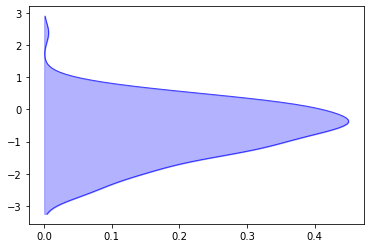

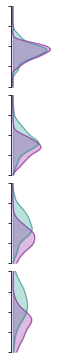

In [17]:
from scipy.stats import gaussian_kde

def plot_pdf(data, ax, color):
    kde = gaussian_kde(data)
    
    yvals = np.linspace(-10, 10, 100)
    pdf_vals = kde(yvals)
    
    ax.fill_betweenx(yvals, pdf_vals, color=color, alpha=0.3)
    ax.plot(pdf_vals, yvals, color=color, alpha=0.7, lw=1)
    
    return ax

f, ax = plt.subplots(nrows=4, figsize=(0.6,5),
                     sharex=True,
                     gridspec_kw={"hspace":0.1, "wspace":0.1,
                                  "left": 0.02,
                                  "right": 0.98,
                                  "top": 0.98,
                                  "bottom": 0.02})

plot_pdf(filtered_pvh.auc_early_licking, ax[0], colors_PVH)
plot_pdf(filtered_vmh.auc_early_licking, ax[0], colors_VMH)

plot_pdf(filtered_pvh.auc_late_licking, ax[1], colors_PVH)
plot_pdf(filtered_vmh.auc_late_licking, ax[1], colors_VMH)

plot_pdf(filtered_pvh.auc_early_post_licking, ax[2], colors_PVH)
plot_pdf(filtered_vmh.auc_early_post_licking, ax[2], colors_VMH)

plot_pdf(filtered_pvh.auc_late_post_licking, ax[3], colors_PVH)
plot_pdf(filtered_vmh.auc_late_post_licking, ax[3], colors_VMH)


for axis in ax:
    axis.set_ylim(-5, 5)
    axis.set_yticklabels([])
    
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.spines["bottom"].set_visible(False)
    axis.set_xticks([])

#ax[2].set_xticklabels([])

f.savefig(FIGSFOLDER / "PVH_VMH_AUC_probability_density_function_2.pdf")



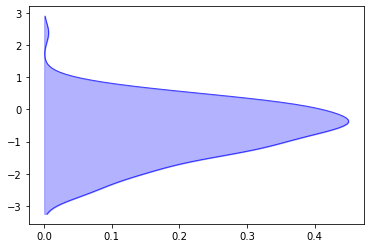

In [201]:
#for finding a good range

def plot_pdf(data, ax, color):
    # Create KDE object
    kde = gaussian_kde(data)
    
    # Determine the data range
    data_range = np.min(data), np.max(data)
    
    # Extend the range slightly beyond the data range
    buffer = (data_range[1] - data_range[0]) * 0.1  # 10% buffer
    yvals = np.linspace(data_range[0] - buffer, data_range[1] + buffer, 100)
    
    # Evaluate KDE
    pdf_vals = kde(yvals)
    
    # Plot the KDE
    ax.fill_betweenx(yvals, pdf_vals, color=color, alpha=0.3)
    ax.plot(pdf_vals, yvals, color=color, alpha=0.7, lw=1)
    
    return ax

# Sample usage
data = filtered_vmh.auc_early_licking
fig, ax = plt.subplots()
plot_pdf(data, ax, 'blue')
plt.show()
